# Testing
### Todesfälle nach aggregierter Todesursache, Altersklasse und Geschlecht, seit 1995
Datum: 23.11.2021

**Importiere die notwendigen Packages**

In [1]:
#pip install geopandas altair fiona requests folium mplleaflet contextily seaborn datetime plotly

In [2]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
from datetime import datetime
import geopandas as gpd
import folium 
import requests

In [3]:
import plotly.express as px


Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [4]:
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

Importiere einen Datensatz von der **DWH_INT** Dropzone.

- Beachte dabei die Notation des Pfades...
- Definiere mal aktuell noch keine weiteren Parameter beim Import

**Dataset auf INTEG Datenkatalog**: https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bfs_bevreg_todesursache-aggregiert_alter_geschlecht_seit1995_od3120

**Dataset auf PROD Datenkatalog**: https://data.stadt-zuerich.ch/dataset/bfs_bevreg_todesursache-aggregiert_alter_geschlecht_seit1995_od3120

In [5]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "prod";
print(status)

prod


In [6]:
# Filepath
if status == "prod":
    fp = r"//szh.loc/ssz/applikationen/OGD_Dropzone/DWH/bfs_bevreg_todesursache-aggregiert_alter_geschlecht_seit1995_od3120/BEV312OD3120.csv"
else:
    fp = r"https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bfs_bevreg_todesursache-aggregiert_alter_geschlecht_seit1995_od3120/download/BEV312OD3120.csv"
#download from INT-Datacatalog:
# https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bfs_bevreg_todesursache-aggregiert_alter_geschlecht_seit1995_od3120/download/BEV312OD3120.csv
print(fp)

//szh.loc/ssz/applikationen/OGD_Dropzone/DWH/bfs_bevreg_todesursache-aggregiert_alter_geschlecht_seit1995_od3120/BEV312OD3120.csv


In [7]:
# Read the data
data2betested = pd.read_csv(
    fp, 
    sep=',',
   #usecols=[0,1,2,3,4,6],
   #names=['stationid','year','month','avgtemp','latitude','longitude','elevation','station','countryid','country'],
   #skiprows=1,
   # parse_dates=[0],
    parse_dates=True,
    #date_parser=lambda x: pd.to_datetime(x, format="%Y"), 
    #index_col="date_time",
    low_memory=False    
    )

In der Folge ein paar erste Tests:

In [8]:
type(data2betested)

pandas.core.frame.DataFrame

 - 1) Zeige eine kurze Vorschau der importierten Daten
 - 2) Weise die Datentypen aus
 - 3) Zeige die Shape (Umfang) des Datensatzes an

In [9]:
data2betested.head(3)

,StichtagDatJahr,TodesursacheSpezSort,TodesursacheSpezLang,AlterVSort_Num,AlterVSort_Nam,AnzSterWir,Geschlecht
0,1995,1200,Alle übrigen Todesursachen,1,0 – 14,12,Frauen
1,1995,1200,Alle übrigen Todesursachen,2,15 – 44,44,Frauen
2,1995,1200,Alle übrigen Todesursachen,3,45 – 64,38,Frauen


In [10]:
data2betested.dtypes

StichtagDatJahr          int64
TodesursacheSpezSort     int64
TodesursacheSpezLang    object
AlterVSort_Num           int64
AlterVSort_Nam          object
AnzSterWir               int64
Geschlecht              object
dtype: object

In [11]:
data2betested.shape

(1211, 7)

Beschreibe einzelne Attribute

In [12]:
data2betested.describe()

,StichtagDatJahr,TodesursacheSpezSort,AlterVSort_Num,AnzSterWir
count,1211,1211,1211,1211
mean,2007,703,3,74
std,7,381,1,97
min,1995,200,1,1
25%,2001,400,2,11
50%,2007,600,3,38
75%,2013,1100,4,89
max,2019,1200,5,626


Wie viele Nullwerte gibt es im Datensatz?

In [13]:
data2betested.isnull().sum()

StichtagDatJahr         0
TodesursacheSpezSort    0
TodesursacheSpezLang    0
AlterVSort_Num          0
AlterVSort_Nam          0
AnzSterWir              0
Geschlecht              0
dtype: int64

Wandle die Spalte Jahr von Int zu **Datetime** um. Dies wird in den meisten Grafiken so benötigt.

In [14]:
data2betested['StichtagDatJahr']=pd.to_datetime(data2betested['StichtagDatJahr'], format='%Y')

#TO DO --> setze das Datum auf den 31.12. der Jahres.
#test=data2betested[['StichtagDatJahr']].date().replace(month=12, day=31)

data2betested

,StichtagDatJahr,TodesursacheSpezSort,TodesursacheSpezLang,AlterVSort_Num,AlterVSort_Nam,AnzSterWir,Geschlecht
0,1995-01-01,1200,Alle übrigen Todesursachen,1,0 – 14,12,Frauen
1,1995-01-01,1200,Alle übrigen Todesursachen,2,15 – 44,44,Frauen
2,1995-01-01,1200,Alle übrigen Todesursachen,3,45 – 64,38,Frauen
3,1995-01-01,1200,Alle übrigen Todesursachen,4,65 – 84,174,Frauen
4,1995-01-01,1200,Alle übrigen Todesursachen,5,85 und älter,149,Frauen
...,...,...,...,...,...,...,...
1206,2019-01-01,500,Kreislaufsystem,5,85 und älter,188,Männer
1207,2019-01-01,1100,Unfälle und Gewalteinwirkungen,2,15 – 44,31,Männer
1208,2019-01-01,1100,Unfälle und Gewalteinwirkungen,3,45 – 64,33,Männer
1209,2019-01-01,1100,Unfälle und Gewalteinwirkungen,4,65 – 84,25,Männer


Bereite die Daten für die Grafik unten vor

In [15]:
Jahre = data2betested.groupby("StichtagDatJahr")
len(Jahre)

25

In [16]:
for key, group in Jahre:
    print(key, len(group))


1995-01-01 00:00:00 51
1996-01-01 00:00:00 51
1997-01-01 00:00:00 49
1998-01-01 00:00:00 47
1999-01-01 00:00:00 50
2000-01-01 00:00:00 52
2001-01-01 00:00:00 48
2002-01-01 00:00:00 49
2003-01-01 00:00:00 48
2004-01-01 00:00:00 51
2005-01-01 00:00:00 50
2006-01-01 00:00:00 47
2007-01-01 00:00:00 48
2008-01-01 00:00:00 49
2009-01-01 00:00:00 49
2010-01-01 00:00:00 48
2011-01-01 00:00:00 48
2012-01-01 00:00:00 50
2013-01-01 00:00:00 49
2014-01-01 00:00:00 46
2015-01-01 00:00:00 45
2016-01-01 00:00:00 44
2017-01-01 00:00:00 47
2018-01-01 00:00:00 49
2019-01-01 00:00:00 46


In [17]:
#Hier nicht notwendig, da es keine Zeitangabe braucht.
#myJahr = "2020-01-01"
#aktuellesJahr=Jahre.get_group(myJahr)   
#aktuellesJahr

**Selektionen und Aggregationen**

Check this [Doku](https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/)

Welche aggregierten Todesursachen gibt es überhaupt?

In [18]:
todesursachen= data2betested.groupby(['TodesursacheSpezSort','TodesursacheSpezLang'])['AnzSterWir'].sum()
todesursachen
# produces Pandas Series
    #data2betested.groupby(['StichtagDatJahr', 'KonOGDSort'])['AnzBestWir'].sum()
# Produces Pandas DataFrame
    #data2betested.groupby(['StichtagDatJahr', 'KonOGDSort'])[['AnzBestWir']].sum()
    

TodesursacheSpezSort  TodesursacheSpezLang          
200                   Krebskrankheiten                  20493
400                   Demenz                             7903
500                   Kreislaufsystem                   31881
600                   Atmungsorgane                      4731
1100                  Unfälle und Gewalteinwirkungen     5481
1200                  Alle übrigen Todesursachen        19229
Name: AnzSterWir, dtype: int64

In [19]:
#data2betested.dtypes

In [20]:
mySelYears = data2betested[(data2betested.StichtagDatJahr == "2019") | (data2betested.StichtagDatJahr == "1995")]
mySelYears

,StichtagDatJahr,TodesursacheSpezSort,TodesursacheSpezLang,AlterVSort_Num,AlterVSort_Nam,AnzSterWir,Geschlecht
0,1995-01-01,1200,Alle übrigen Todesursachen,1,0 – 14,12,Frauen
1,1995-01-01,1200,Alle übrigen Todesursachen,2,15 – 44,44,Frauen
2,1995-01-01,1200,Alle übrigen Todesursachen,3,45 – 64,38,Frauen
3,1995-01-01,1200,Alle übrigen Todesursachen,4,65 – 84,174,Frauen
4,1995-01-01,1200,Alle übrigen Todesursachen,5,85 und älter,149,Frauen
...,...,...,...,...,...,...,...
1206,2019-01-01,500,Kreislaufsystem,5,85 und älter,188,Männer
1207,2019-01-01,1100,Unfälle und Gewalteinwirkungen,2,15 – 44,31,Männer
1208,2019-01-01,1100,Unfälle und Gewalteinwirkungen,3,45 – 64,33,Männer
1209,2019-01-01,1100,Unfälle und Gewalteinwirkungen,4,65 – 84,25,Männer


### Daten in interaktiver Treemap zeigen
Dazu gibt es eine sehr nützliche Webseite https://plotly.com/python/treemaps/
Zu Farbskalen, siehe: https://plotly.com/python/builtin-colorscales/

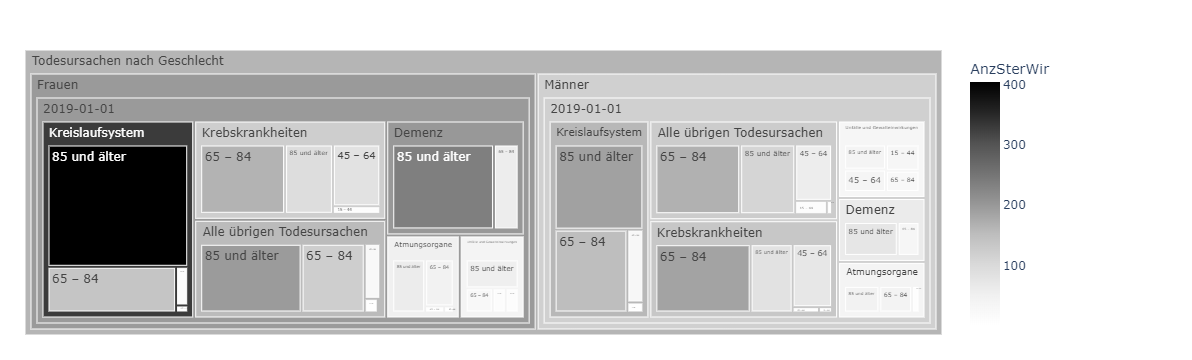

In [58]:
df = mySelYears
fig = px.treemap(df, path=[px.Constant("Todesursachen nach Geschlecht"), 'Geschlecht','StichtagDatJahr','TodesursacheSpezLang', 'AlterVSort_Nam'], values='AnzSterWir',
                color='AnzSterWir', hover_data=['TodesursacheSpezLang'],
                color_continuous_scale='greys')
                #color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir']))
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()


In [59]:
fig.write_html("C:/Users/sszsim/Downloads/todesfaelle_nach_geschlecht_ursache_alter.html")

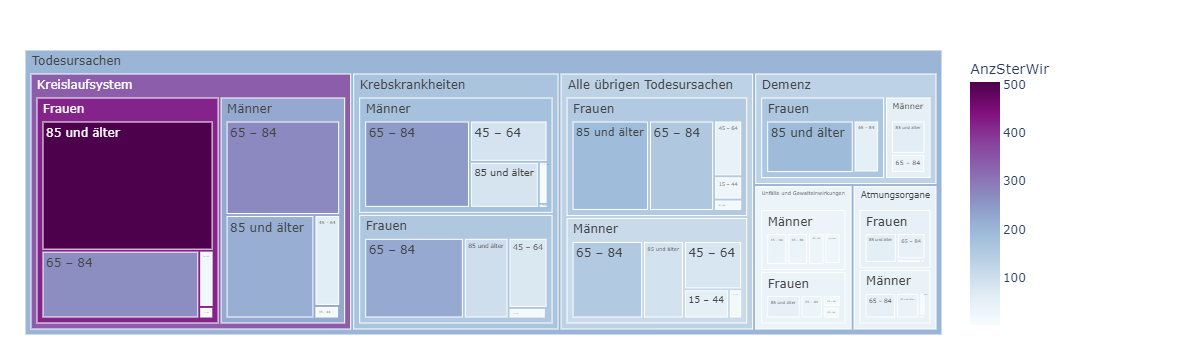

In [60]:
df = data2betested
fig = px.treemap(df, path=[px.Constant("Todesursachen"), 'TodesursacheSpezLang', 'Geschlecht', 'AlterVSort_Nam'], values='AnzSterWir',
                color='AnzSterWir', hover_data=['TodesursacheSpezLang'],
                color_continuous_scale='BuPu')
                #color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir']))
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()



In [61]:
fig.write_html("C:/Users/sszsim/Downloads/todesursachen_geschlecht_alter.html")

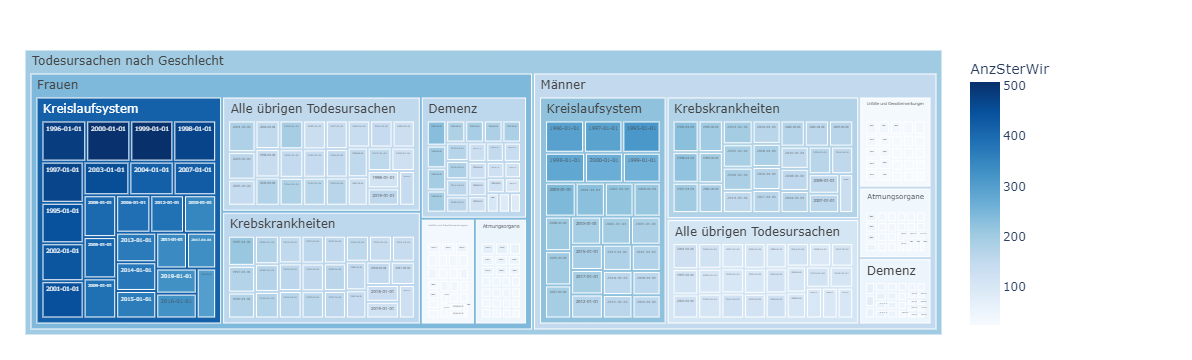

In [62]:
df = data2betested
fig = px.treemap(df, path=[px.Constant("Todesursachen nach Geschlecht"), 'Geschlecht', 'TodesursacheSpezLang', 'StichtagDatJahr'], values='AnzSterWir',
                color='AnzSterWir', hover_data=['TodesursacheSpezLang'],
                color_continuous_scale='blues')
                #color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir']))
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

In [63]:
fig.write_html("C:/Users/sszsim/Downloads/todesursachen_geschlecht.html")

### Einfache Visualisierungen zur Plausi

Exploriere die Daten mit Pivottable.JS

In [24]:
from pivottablejs import pivot_ui

pivot_ui(data2betested)

Liniendiagramm 
[Link zur Doku](https://altair-viz.github.io/gallery/multiline_highlight.html)

In [25]:
mySelYears = data2betested[(data2betested.StichtagDatJahr == "2019")]


In [26]:
#myGraph= mySelYears[['TodesursacheSpezSort','TodesursacheSpezLang', 'AlterVSort_Nam', 'AnzSterWir']]
myGraph= mySelYears.groupby(['TodesursacheSpezSort','TodesursacheSpezLang', 'AlterVSort_Nam'])[['AnzSterWir']].sum()
myGraph


AnzSterWir
TodesursacheSpezSort TodesursacheSpezLang           AlterVSort_Nam            
200                  Krebskrankheiten               0 – 14                   2
                                                    15 – 44                 14
                                                    45 – 64                153
                                                    65 – 84                351
                                                    85 und älter           175
400                  Demenz                         65 – 84                 87
                                                    85 und älter           309
500                  Kreislaufsystem                15 – 44                  6
                                                    45 – 64                 40
                                                    65 – 84                288
                                                    85 und älter           592
600                  Atmungsorgane                  15 – 44                  2
                                                    45 – 64                 13
                                                    65 – 84                 86
                                                    85 und älter           103
1100                 Unfälle und Gewalteinwirkungen 15 – 44                 42
                                                    45 – 64                 44
                                                    65 – 84                 48
                                                    85 und älter            91
1200                 Alle übrigen Todesursachen     0 – 14                   3
                                                    15 – 44                 17
                                                    45 – 64                 83
                                                    65 – 84                290
                                                    85 und älter           305

In [27]:
myGraph.dtypes

AnzSterWir    int64
dtype: object

In [28]:
# df_statzonen = df_statzonen[(df_statzonen.knr>0) & (df_statzonen.qname!="Hirslanden")]
#aktuellesJahr[[aktuellesJahr.KreisSort =7]])

highlight = alt.selection(type='single', on='mouseover',
                          fields=['AlterVSort_Nam'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myGraph).encode(
    x='AlterVSort_Nam',
    y='AnzSterWir',
    color='TodesursacheSpezLang'
)

points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=700 , height=500
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(1.5), alt.value(4))
).interactive()

points + lines

ValueError: Hierarchical indices not supported

alt.LayerChart(...)

In [29]:
alt.Chart(myGraph).mark_circle(size=60).encode(
    x='AlterVSort_Nam',
    y='AnzSterWir',
    color='TodesursacheSpezLang',
    tooltip=['AlterVSort_Nam','AnzSterWir']
).interactive() # this makes the axes interactive: now you can zoom & pan


ValueError: Hierarchical indices not supported

alt.Chart(...)

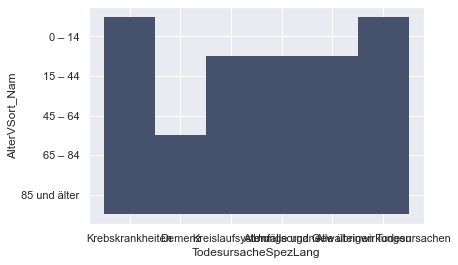

In [30]:
import seaborn as sns
sns.set(style="darkgrid")
sns.histplot(data=myGraph, x="TodesursacheSpezLang", y="AlterVSort_Nam") #, y="Nachname")
plt.show();